<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [1]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import xarray
import random
import dawgz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.insert(1, '../src/')
sys.path.insert(1, '../scripts/')

# Loading libraries
from dataset              import BlackSea_Dataset
from dataloader           import BlackSea_Dataloader
from dataset_evolution    import BlackSea_Dataset_Evolution
from dataset_distribution import BlackSea_Dataset_Distribution

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to the .py directory
%cd ../src/

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
/Users/vikvador/Documents/esa/ESA---Black-Sea-Deoxygenation/src


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Scripts</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Analyzing the data (1):
%run script_distribution.py --start_year        0 \
                            --end_year          0 \
                            --start_month       1 \
                            --end_month         2 \
                            --dawgz         False

In [ ]:
# Analyzing the data (2):
%run script_evolution.py --start_year        0 \
                         --end_year          0 \
                         --start_month       1 \
                         --end_month         2 \
                         --dawgz         False

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [2]:
# -----------------
#    Parameters
# -----------------
#
# Time window
month_starting = 1
month_ending   = 1
year_starting  = 0
year_ending    = 0

# Maximum depth observed for oxygen, what is left is masked [m] (Note: To observe only the continental shelf set it to ~120m).
depth_max_oxygen = None

# ------------------
#  Loading the data
# ------------------
# Datasets !
Dataset_physical = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "grid_T")
Dataset_bio      = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "ptrc_T")

# Loading the different field values
data_oxygen        = Dataset_bio.get_oxygen_bottom(depth = depth_max_oxygen)
data_temperature   = Dataset_physical.get_temperature()
data_salinity      = Dataset_physical.get_salinity()
data_chlorophyll   = Dataset_bio.get_chlorophyll()
data_kshort        = Dataset_bio.get_light_attenuation_coefficient_short_waves()
data_klong         = Dataset_bio.get_light_attenuation_coefficient_long_waves()

# Loading the black sea mask
BS_mask = Dataset_physical.get_blacksea_mask()

# --------------------
#  Preparing the data
# --------------------
# Loading the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature, data_salinity, data_chlorophyll, data_kshort, data_klong],
                                 y = data_oxygen,
                              mask = BS_mask,
                              mode = "temporal",
                        resolution = 64,
                            window = 7,
                        window_oxy = 7)

# Rertieving the datasets
ds_train      = BSD_loader.get_dataloader("train")
ds_validation = BSD_loader.get_dataloader("validation")
ds_test       = BSD_loader.get_dataloader("test")

In [26]:
def generateFakeDataset(number_of_variables: int = 5, number_of_samples: int = 14, resolution : int = 64):
    """Used to generate a fake dataset for testing purposes, i.e. each zone will be named to become easily recognizable"""

    # Stores all the fake samples
    list_fake_samples = [[] for i in range(number_of_variables)]

    # A simple list of letters to define the variables
    list_variables = ["T", "S", "C", "Ks", "Kl"]

    def add_text_to_image(image: np.array, text: str, position: tuple, font_size: int = 0.6, thickness: int = 2):
        r"""Used to add some text on image"""
        return cv2.putText(image, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_size, (0,0,0), thickness, cv2.LINE_AA)

    # Creation of the fake samples
    for v in range(number_of_variables):
        for s in range(number_of_samples):

            # Creation of a snapshot
            snapshot = np.ones(shape = (258, 578))

            # Indexes used for the grid
            index_i = int((snapshot.shape[0] - 2)  / resolution)
            index_j = int((snapshot.shape[1] - 2)  / resolution)

            # Adding horizontal lines
            for i in range(0, index_i):
                snapshot[i * resolution, :] = 0

            # Adding vertical lines
            for j in range(0, index_j):
                snapshot[:, j * resolution] = 0

            # Adding dummy zone notations
            for i in range(0, index_i + 1):
                for j in range(0, index_j + 1):

                    # Computing the middle of the zone
                    x = int((j - 1) * resolution + resolution / 2)
                    y = int((i - 1) * resolution + resolution / 2)

                    # Adding the zone notation (+- to adjust position manually)
                    snapshot = add_text_to_image(snapshot, f"{list_variables[v]}{s}", (x - 10, y + 7))

            # Adding the snapshot to the list of fake samples
            list_fake_samples[v].append(snapshot)

    # Concatenates all the list as one numpy matrix
    list_fake_samples = np.array(list_fake_samples)

    # Swaps the axis to have the right shape, i.e. (v, t, x, y) to (t, v, x, y)
    return list_fake_samples

In [27]:
fake_data_physical_variables = generateFakeDataset(resolution = 64, number_of_variables = 3, number_of_samples = 10)
fake_data_physical_oxygen    = generateFakeDataset(resolution = 64, number_of_variables = 1, number_of_samples = 10)

print(fake_data_physical_oxygen.shape, fake_data_physical_variables.shape)

BSD_loader_fake = BlackSea_Dataloader(x = fake_data_physical_variables,
                                 y = fake_data_physical_oxygen,
                              mask = np.ones(shape = (258, 578)),
                              mode = "temporal",
                        resolution = 64,
                            window = 7,
                        window_oxy = 7)

for x, y in BSDBSD_loader_fake_loader.get_dataloader("train"):
    print(x.shape)
    print(y.shape)
    plt.imshow(y[1, 0, :, :])
    break

(1, 10, 258, 578) (3, 10, 258, 578)


ValueError: too many values to unpack (expected 4)

In [22]:
BSD_loader = BlackSea_Dataloader(x = fake_data,
                                 y = data_oxygen,
                              mask = BS_mask,
                              mode = "temporal",
                        resolution = 64,
                            window = 7,
                        window_oxy = 7)

torch.Size([32, 28, 64, 64])
torch.Size([32, 7, 64, 64])


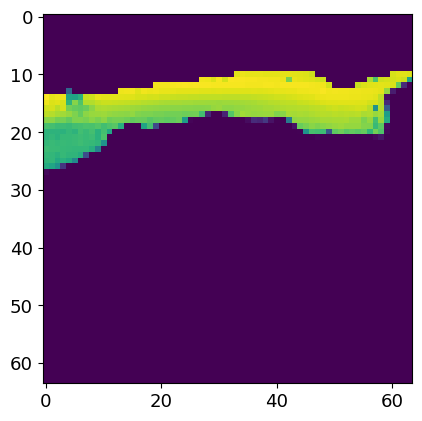

In [23]:
for x, y in BSD_loader.get_dataloader("train"):
    print(x.shape)
    print(y.shape)
    plt.imshow(y[1, 0, :, :])
    break